# Proportion of Variance Explained and Heritability

Proportion of variance explained (PVE) measures how much of the total variation in a trait (like height or disease risk) can be **attributed** to specific variables in your statistical model (e.g., genetic variants). Heritability is a specific application of this concept that measures how much of the **variation** in a trait across a population **can be explained by genetic differences**.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide12.png)

# Key Formula

Any phenotype can be modeled as the sum of genetic (G) and environmental (E) effects, their interaction (G×E), and a residual error term (ε) that captures unexplained variation: $Y = G + E + G \times E + \epsilon$. Under the assumptions that (1) genetic and environmental effects are independent, i.e., $\text{Cov}(G,E) = 0$, and (2) the error term is uncorrelated with genetic effects, i.e., $\text{Cov}(G,\epsilon) = 0$, the **proportion of variance explained (PVE)** by genetic effects alone (also called broad-sense heritability $H^2$) can be derived as:

$$
\text{PVE} = H^2 = \frac{\sigma^2_G}{\sigma^2_Y}
$$

where:
- $\sigma^2_G$ is the genetic variance component
- $\sigma^2_Y$ is the total phenotypic variance

# Technical Details

## Generative Model

A formal generative model specifies the probability distributions and relationships between variables:

$$
\begin{align}
Y_i | \mu_i, \sigma^2_{\epsilon} &\sim N(\mu_i, \sigma^2_{\epsilon}) \\
\mu_i &= \beta_0 + G_i + E_i + (G \times E)_i
\end{align}
$$

where the components follow:

$$
G_i \sim N(0, \sigma^2_G), \quad E_i \sim N(0, \sigma^2_E), \quad (G \times E)_i \sim N(0, \sigma^2_{GE}), \quad \epsilon_i \sim N(0, \sigma^2_{\epsilon})
$$

**Key independence assumptions one can generally make**: 
- $G \perp E$ (genetic and environmental effects are independent)
- $G \perp \epsilon$ (genotype uncorrelated with residual error)
- $E \perp \epsilon$ (environment uncorrelated with residual error)

Violations occur when omitted confounders correlate with genotype, or when $G \times E$ interactions exist but aren't modeled, causing them to be absorbed into $\epsilon$.

## Variance Decomposition

Under the independence assumptions:

$$
\sigma^2_Y = \sigma^2_G + \sigma^2_E + \sigma^2_{GE} + \sigma^2_{\epsilon}
$$

If independence is violated (e.g., $\text{Cov}(G,E) \neq 0$ or $\text{Cov}(G,\epsilon) \neq 0$), covariance terms appear:

$$
\sigma^2_Y  = \sigma^2_G + \sigma^2_E + \sigma^2_{GE} + \sigma^2_{\epsilon} + 2\text{Cov}(G,E) + \text{other terms}
$$

This leads to biased heritability estimates. In practice, $\sigma^2_E$ and $\sigma^2_{\epsilon}$ are often combined since distinguishing environmental from residual variance requires experimental manipulation.

## Broad-sense Heritability

$$
H^2 = \frac{\sigma^2_G}{\sigma^2_Y} = \frac{\sigma^2_G}{\sigma^2_G + \sigma^2_E + \sigma^2_{GE} + \sigma^2_{\epsilon}}
$$

This represents the proportion of phenotypic variance from all genetic effects (additive + dominance + epistatic). $H^2$ is population- and environment-specific, not a fixed biological constant.

## Narrow-sense Heritability

The genetic variance can be decomposed into:

$$
\sigma^2_G = \sigma^2_A + \sigma^2_D +  \sigma^2_R + \sigma^2_I
$$

where $\sigma^2_A$ is additive variance, $\sigma^2_D$ is dominance variance, $\sigma^2_R$ is recessive variance, and $\sigma^2_I$ is epistatic variance.

$$
h^2 = \frac{\sigma^2_A}{\sigma^2_Y}
$$

Narrow-sense heritability captures only additive genetic effects. This is what GWAS, eQTL mapping, and polygenic risk scores estimate, since these methods model linear allelic effects. The difference $H^2 - h^2$ reflects non-additive genetic architecture.

# Related Topics

- [ordinary least square](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [odds ratio](https://statfungen.github.io/statgen-primer/odds_ratio.html)
- [random effect](https://statfungen.github.io/statgen-primer/random_effect.html)
- [LD scores](https://statfungen.github.io/statgen-primer/linkage_disequilibrium_score.html)

# Example

When we say a trait has "50% heritability," we mean 50% of the variation in that trait across individuals is due to genetic differences. Let's explore this with 100 individuals whose phenotype is influenced by:

- Variant 1: additive effect
- Variant 2: dominant effect (any non-zero genotype)
- Interaction between variants 1 and 2
- Environmental factor
- Residual/unexplained variation

We'll calculate $H^2$ (broad-sense heritability) and $h^2$ (narrow-sense heritability) under both fixed and random effect models.

In [1]:
rm(list = ls())
set.seed(11)

# Define parameters
N <- 100  # Number of individuals
M <- 2    # Number of variants

# Generate genotype data directly as allele counts (0, 1, 2)
# Variant 1: additive effect, MAF = 0.3
variant1 <- sample(0:2, N, replace = TRUE, prob = c(0.49, 0.42, 0.09))

# Variant 2: dominance effect, MAF = 0.5
variant2 <- sample(0:2, N, replace = TRUE, prob = c(0.25, 0.5, 0.25))

# Combine into raw genotype matrix
X_raw <- cbind(variant1, variant2)
rownames(X_raw) <- paste("Individual", 1:N)
colnames(X_raw) <- c("Variant1_Additive", "Variant2_Dominant")

# Create dominance coding for variant 2
# Dominance coding: 1 if genotype is not 0 (i.e., has at least one alternative allele)
Xraw_dominance <- ifelse(X_raw[, 2] != 0, 1, 0)

# Create interaction term: variant1 (additive) × variant2 (dominance)
Xraw_interaction <- X_raw[, 1] * Xraw_dominance

# Generate environmental variable
# For example, this could represent diet, exercise, stress, etc.
E_raw <- rnorm(N, mean = 0, sd = 1)

# Standardize all components
X_additive <- scale(X_raw[, 1], center = TRUE, scale = TRUE)
X_dominance <- scale(Xraw_dominance, center = TRUE, scale = TRUE)
X_interaction <- scale(Xraw_interaction, center = TRUE, scale = TRUE)
E <- scale(E_raw, center = TRUE, scale = TRUE)

## Fixed Effect

Effect sizes are constant parameters:

$$Y = X_{add} \beta_A + X_{dom} \beta_D + X_{int} \beta_I + E \beta_E + \epsilon$$

In [2]:
# Fixed effects: constant effect sizes
beta_A <- 0.8   # Additive effect
beta_D <- 0.6   # Dominance effect
beta_I <- 0.4   # Interaction effect
beta_E <- 0.5   # Environmental effect

# Generate phenotype
epsilon <- rnorm(N, mean = 0, sd = 1)
Y <- X_additive * beta_A + X_dominance * beta_D + X_interaction * beta_I + E * beta_E + epsilon

Calculate variance components and heritability:

Heritability:
  H² (broad-sense):       0.4138 
  h² (narrow-sense):      0.2283 
  H² - h² (non-additive): 0.1855 


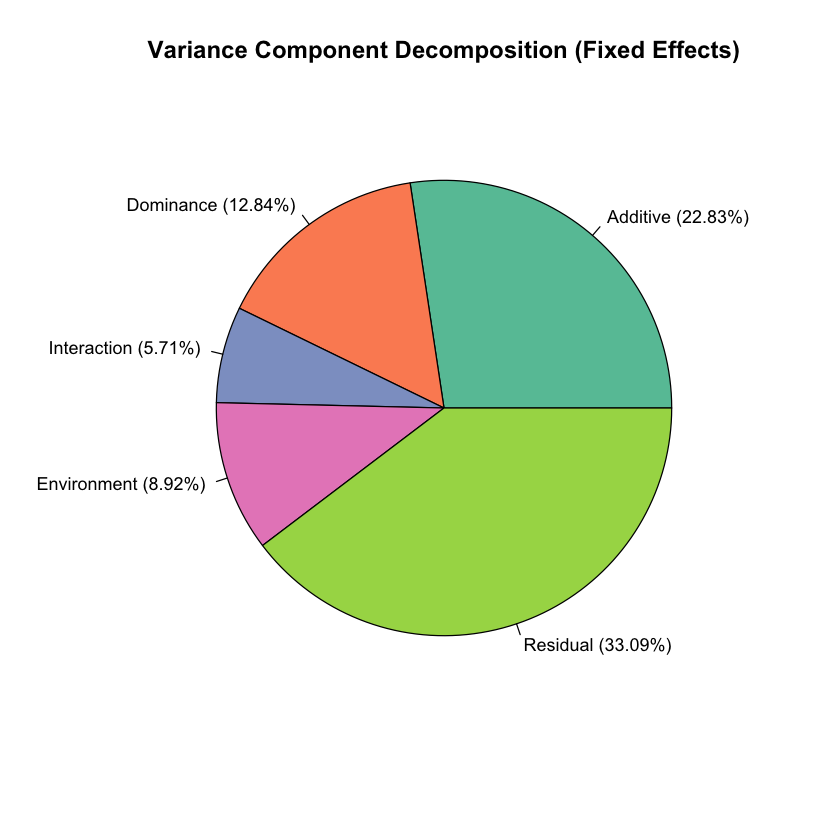

In [3]:
# Calculate variance components
var_A <- var(X_additive * beta_A)
var_D <- var(X_dominance * beta_D)
var_I <- var(X_interaction * beta_I)
var_G <- var_A + var_D + var_I
var_E <- var(E * beta_E)
var_epsilon <- var(epsilon)
var_Y <- var(Y)

# Calculate heritabilities
H2 <- var_G / var_Y
h2 <- var_A / var_Y

# Display results
cat("Heritability:\n")
cat("  H² (broad-sense):      ", round(H2, 4), "\n")
cat("  h² (narrow-sense):     ", round(h2, 4), "\n")
cat("  H² - h² (non-additive):", round(H2 - h2, 4), "\n")

# Create pie chart of variance components
library(RColorBrewer)
colors <- brewer.pal(5, "Set2")

variance_data <- c(var_A, var_D, var_I, var_E, var_epsilon)
variance_labels <- c(
  paste0("Additive (", round(var_A/var_Y*100, 2), "%)"),
  paste0("Dominance (", round(var_D/var_Y*100, 2), "%)"),
  paste0("Interaction (", round(var_I/var_Y*100, 2), "%)"),
  paste0("Environment (", round(var_E/var_Y*100, 2), "%)"),
  paste0("Residual (", round(var_epsilon/var_Y*100, 2), "%)")
)

pie(variance_data, labels = variance_labels, col = colors, 
    main = "Variance Component Decomposition (Fixed Effects)",
    cex = 0.9)

## Random effect

Effect sizes are drawn from distributions for each individual:

$$\beta_{A,i} \sim N(0, \sigma^2_{\beta_A}), \quad \beta_{D,i} \sim N(0, \sigma^2_{\beta_D}), \quad \beta_{I,i} \sim N(0, \sigma^2_{\beta_I}), \quad \beta_{E,i} \sim N(0, \sigma^2_{\beta_E})$$

In [4]:
# Random effects: draw effect sizes from distributions
beta_A_random <- rnorm(N, mean = 0, sd = 1.0)
beta_D_random <- rnorm(N, mean = 0, sd = 0.8)
beta_I_random <- rnorm(N, mean = 0, sd = 0.5)
beta_E_random <- rnorm(N, mean = 0, sd = 0.6)

Generate phenotype and calculate heritability:

Heritability (Random Effects):
  H² (broad-sense):       0.5112 
  h² (narrow-sense):      0.2328 
  H² - h² (non-additive): 0.2784 


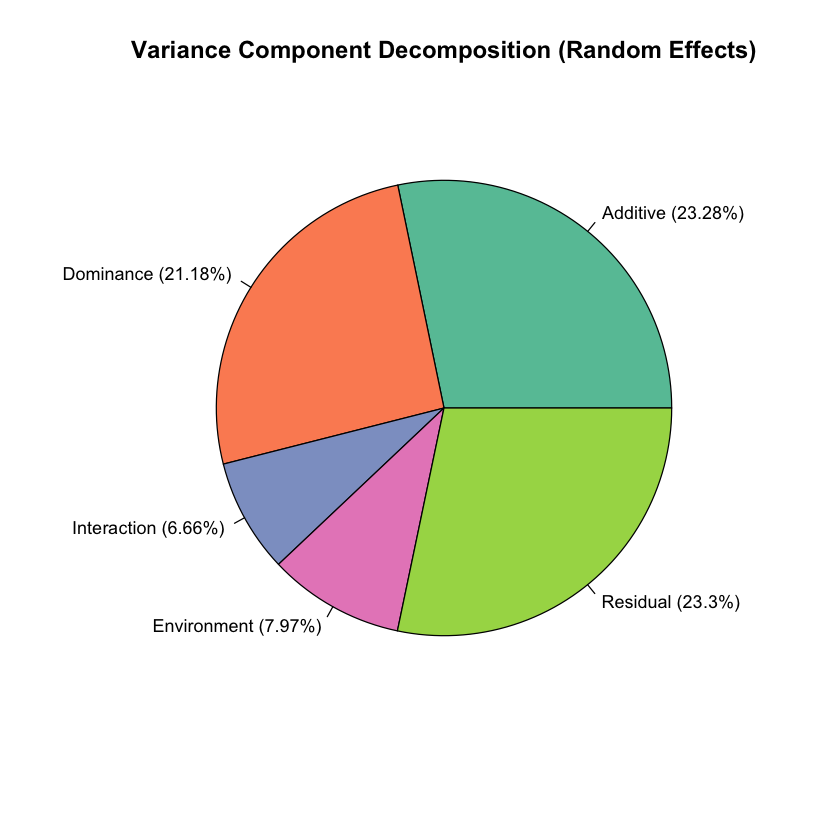

In [5]:
# Generate phenotype with random effects
epsilon <- rnorm(N, mean = 0, sd = 1)
Y <- X_additive * beta_A_random + X_dominance * beta_D_random + X_interaction * beta_I_random + E * beta_E_random + epsilon

# Calculate variance components
var_A_random <- var(X_additive * beta_A_random)
var_D_random <- var(X_dominance * beta_D_random)
var_I_random <- var(X_interaction * beta_I_random)
var_G_random <- var_A_random + var_D_random + var_I_random
var_E_random <- var(E * beta_E_random)
var_epsilon_random <- var(epsilon)
var_Y_random <- var(Y)

# Calculate heritabilities
H2_random <- var_G_random / var_Y_random
h2_random <- var_A_random / var_Y_random

# Display results
cat("Heritability (Random Effects):\n")
cat("  H² (broad-sense):      ", round(H2_random, 4), "\n")
cat("  h² (narrow-sense):     ", round(h2_random, 4), "\n")
cat("  H² - h² (non-additive):", round(H2_random - h2_random, 4), "\n")

# Create pie chart of variance components
variance_data_random <- c(var_A_random, var_D_random, var_I_random, var_E_random, var_epsilon_random)
variance_labels_random <- c(
  paste0("Additive (", round(var_A_random/var_Y_random*100, 2), "%)"),
  paste0("Dominance (", round(var_D_random/var_Y_random*100, 2), "%)"),
  paste0("Interaction (", round(var_I_random/var_Y_random*100, 2), "%)"),
  paste0("Environment (", round(var_E_random/var_Y_random*100, 2), "%)"),
  paste0("Residual (", round(var_epsilon_random/var_Y_random*100, 2), "%)")
)

pie(variance_data_random, labels = variance_labels_random, col = colors, 
    main = "Variance Component Decomposition (Random Effects)",
    cex = 0.9)